# High-Frequency Effects and Modelling on FX Market in Response to US Macroeconomic Data Releases

## Steps:
1. <span style="color:green">Research and Planning
    * Define clear research goals and objectives
    * Decide on macroeconomic events and FX pairs</span>
2. Literature Review
    * Review past papers
    * <span style="color:green">Identify gaps (model that does stress testing, probability w/ price range, capturing retracement/correction)</span>
3. Data Collection and Processing
    *  <span style="color:green">Identify data sources</span>
    * <span style="color:green">Collect FX pairs (date, minute interval, open, low, high, close)
    * <span style="color:green">Collect macroeconomic events (date, expected value, actual value)</span>
    * <span style="color:green">Merge datasets</span>
    * <span style="color:green">Keep only data with the macro events (not whole month but only on data releases)</span>
    * Do some analysis for data dimensionality (e.g., analysis whether to keep 10 minutes before and 10 minutes after only of the data release)
4. Exploratory Analysis
    * Correlation of price movement with each macro event expected vs actual
    * Feature importance (which macro event brings more volume)
    * Variance after the events (volatility)
5. <span style="color:orange">Model Development
    * Create some probabilistic TS model based on historical data
6. <span style="color:orange">Backtesting and Market Simulation
    * KPIs and statistical measurement of model on test data (can be same as past)
    * Create a class/function to take input of a pair, expected value of macro data, and minute after event to give some price range and classification with confidence interval
7. <span style="color:orange">Results and Discusion
    * Interpret market reactions to economic data
    * Compare model accuracy with benchmarks</span>

----------------------

# <span style="color:blue">Libraries</span>

In [54]:
# Libraries for data fetching
import yfinance as yf
from polygon import RESTClient
from fredapi import Fred

# Libraries for data analysis
import pandas as pd
import numpy as np

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Libraries for time handling
import time  
from datetime import timedelta

# Libraries for feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

----------------------

# <span style="color:blue">Data Retrieval</span>
* Data Collection FX pair tickers (symbols) for **Yahoo Finance**: 
    * **DXY** 🠆 "DX-Y.NYB",
    * **USD/GBP** 🠆 "GBPUSD=X",
    * **USD/EUR** 🠆 "EURUSD=X",
    * **USD/CNY** 🠆 "CNY=X"


* Data Collection FX pair tickers (symbols) for **Polygon.io**:
    * **USD/EUR** 🠆 C:USD/EUR
    * **USD/GBP** 🠆 C:USD/GBP
    * **USD/CNY** 🠆 C:USD/CHF
    
* Data Collection FX pair tickers (symbols) for **fred.stlouisfed.org**:
    * **Inflation** 🠆 CPIAUCSL
    * **Interest Rates** 🠆 FEDFUNDS
    * **GDP** 🠆 GDPC1
    * **Unemployment Rate** 🠆 UNRATE
    * **PMI** 🠆 NAPM
    * **DXY** 🠆 DTWEXBGS
    
* Macroeconomic events **Bloomberg Terminal (KCL)** (macro_data_bloomberg.csv):
    * **INTR** (every 6-weeks)
    * **CPI** (MoM)
    * **GDP** (QoQ)
    * **PCE** (MoM)
    * **UNRATE** (MoM)
    * **PMI** (MoM)

In [61]:
def polygon_get_fx_data(fx_pair, interval, start_date, end_date, api_key='0GbCWQKVtPfEMJvPmc1n50psE3zsW1c8'):
    """
    Retrieve historical FX data from Polygon.io.

    Parameters:
    - interval (str): The interval for the data ('1m', '5m', '1h', '1d').
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format.
    - api_key (str): Polygon.io API key.

    Returns:
    - pd.DataFrame: A DataFrame containing historical USD/CNY forex data.
    """
    try:
        # Bring the fx pair ticker to Polygon's format
        fx_pair_polygon_formated = "C:" + str(fx_pair)

        client = RESTClient(api_key)

        # Request data
        data_request = client.get_aggs(
            ticker=fx_pair_polygon_formated, 
            multiplier=1, 
            timespan=interval,
            from_=start_date, 
            to=end_date
        )
    
        # Convert response to DataFrame
        df = pd.DataFrame(data_request)
        
        # Check if data is returned
        if df.empty:
            print("No data found.")
            return None

        # Convert timestamp to datetime format and set Datetime as an index
        df["Datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("Datetime", inplace=True)
        
        # Drop columns not needed
        df = df.drop(columns=["otc", "transactions", "timestamp"])
        
        # Rename columns to align with yf for the feature engineering and merging later on
        df = df.rename(columns={"high": "High", "low": "Low", "close": "Adj Close", "volume": "Volume"})
        df = df.rename_axis(f'{fx_pair}', axis=1)
        
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None
        
macro_df = pd.read_csv("macro_bloomberg_data.csv")

----------------------

# <span style="color:blue">Data Preprocessing</span>
1. Replace '--' to null
2. DateTime format (some years to 2 digits some 4 e.g., 2025 and 25)
3. Convert to DateTime
4. Replace the % to decimals and convert to float

In [62]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Finds for  '--' values and converts them to NaN. 
    Afterwards, drop rows where Expected and Actual are NaN.
    
    Parameters:
    - df ()
    """
    # Missing values convert from '--' to NaN
    df.replace('--', np.nan, inplace=True)

    # Drop rows where Expected and Actual are missing
    df = macro_df.dropna(subset=["Expected", "Actual"], how="all")
    
    return df



def standardize_datetime_format(df: pd.DataFrame, column_name="Date Time") -> pd.DataFrame:
    """
    Standardizes the Date Time column to the format MM/DD/YYYY HH:MM,
    converts it to a datetime datatype, sets it as the index, and sorts the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to be formatted.
    - column_name (str): The name of the column to standardize.

    Returns:
    - pd.DataFrame: The DataFrame with the standardized datetime format, 
                    set as index, and sorted.
    """
    def fix_date_format(date_str):
        # Try parsing with two-digit year format first
        dt = pd.to_datetime(date_str, format='%m/%d/%y %H:%M', errors='coerce')
        
        # If conversion fails, try four-digit year format
        if pd.isnull(dt):
            dt = pd.to_datetime(date_str, format='%m/%d/%Y %H:%M', errors='coerce')
        
        return dt  # Return as datetime object

    # Apply the function to convert to datetime
    df = df.copy(deep=True)
    df["Datetime"] = df[column_name].astype(str).apply(fix_date_format)
    
    # Drop rows where conversion failed
    df = df.dropna(subset=["Datetime"])
    # Drop previous 'Date Time'
    df.drop(columns=['Date Time'], inplace=True)

    # Convert the column to datetime dtype
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Set Date Time as index
    df = df.set_index("Datetime")

    # Sort DataFrame by the Date Time index
    df = df.sort_index()

    return df



def convert_percentage_to_numeric(df: pd.DataFrame, columns=["Expected", "Actual", "Prior"]) -> pd.DataFrame:
    """
    Converts percentage values in specified columns to numerical float values.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing percentage values.
    - columns (list): List of column names to convert.

    Returns:
    - pd.DataFrame: DataFrame with percentage values converted to floats.
    """
    for col in columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=True).astype(float)
    
    return df



def clean_macro_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the 'Event' column and renames 'Ticker' values to standardized names.

    Parameters:
    - df (pd.DataFrame): The macroeconomic DataFrame.

    Returns:
    - pd.DataFrame: Cleaned DataFrame with renamed tickers.
    """
    
    # Drop the 'Event' column
    df = df.drop(columns=["Event"], errors="ignore")

    # Dictionary mapping for renaming
    ticker_mapping = {
        "UNRATE": "UNRATE",
        "CPI_MoM": "CPI",
        "INTR": "INTR",
        "PCE_MoM": "PCE",
        "GDP_QoQ": "GDP",
        "PMI": "PMI"
    }

    # Rename cols
    df["Ticker"] = df["Ticker"].replace(ticker_mapping)

    return df

----------------------

# <span style="color:blue">Feature Engineering</span>

In [63]:
def surprise_calculation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the surprise (difference) of Expected vs Actual.
    
    Parameters:
    - df (pd.DataFrame): macro economic data

    Returns:
    - pd.DataFrame: Original dataframe plus the surprise column.
    """
    
    df["Surprise"] = df["Actual"] - df["Expected"]
    return df


def calculate_volatility(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average volatility dynamically based on the number of rows in the DataFrame.

    Parameters:
    - df (pd.DataFrame): FX data.

    Returns:
    - pd.DataFrame: The original DataFrame with added 'Volatility', 
                                                    'Average_Volatility', 
                                                    and 'Volatility_Multiplier' columns.
    """

    if df is None or df.empty:
        print("Error: DataFrame is empty or invalid.")
        return None
    if "Adj Close" in df.columns:
        # Compute Volatility
        df['Volatility'] = np.abs(np.log(df['Adj Close'] / df['Adj Close'].shift(1)))
    else:
        df['Volatility'] = np.abs(np.log(df['Close'] / df['Close'].shift(1)))
        
    # Compute Average Volatility based on number of rows
    df['Average_Volatility'] = df['Volatility'].mean()
    # Compute Volatility Multiplier
    df['Volatility_Multiplier'] = round(df['Volatility'] / df['Average_Volatility'],2)

    return df

------------

# <span style="color:blue">Plotting Functions</span>

In [143]:
#######################################################################
########################### Plot a Column #############################

def plot_time_series(df, column):
    """
    Plots a time series for a given data and column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing time series data with a Datetime index.
    - column (str): Column name to plot.
    - title (str): Title of the plot (default: "Time Series Plot").

    Returns:
    - None (Displays the plot)
    """
    
    if column not in df.columns:
        print(f"Error: Column '{column}' not found in DataFrame.")
        return None
    
    fx_pair = df.columns.name if df.columns.name else "FX Pair"
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    df[column].plot(ax=ax)
    
    # Improve x-axis readability
    ax.set_xlabel("Datetime", fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    ax.set_title(f"'{fx_pair}' {column} Over Time", fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    
    # Ensure the x-axis starts and ends exactly at the first and last data points (applicable only to yf data)
    if "vwap" not in df.columns:
        # Format x-axis to time
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.set_xlim(df.index.min(), df.index.max())

    ax.grid(True, which="major", linestyle="-", linewidth=0.6, alpha=1)  
    ax.grid(True, which="minor", linestyle="-", linewidth=0.5, alpha=1) 

    plt.show()
    pass


########################################################################
################### Event Volatility Time Analysis #####################

def plot_time_differences(time_differences, avg_start, avg_end):
    """
    Plots the distribution of time differences from event timestamps.

    Parameters:
    - time_differences (list): List of (start_diff, end_diff) tuples.
    - avg_start (float): Average start time difference.
    - avg_end (float): Average end time difference.
        
    Returns:
    - None (Displays the plot)
    """
    start_diffs = [diff[0] for diff in time_differences]
    end_diffs = [diff[1] for diff in time_differences]

    plt.figure(figsize=(10, 6))

    # Histogram for start & end differences
    sns.histplot(start_diffs, bins=20, kde=True, color="blue", label="Start Time Difference", alpha=0.6)
    sns.histplot(end_diffs, bins=20, kde=True, color="red", label="End Time Difference", alpha=0.6)

    # Average lines
    plt.axvline(avg_start, color="blue", linestyle="--", label=f"Avg Start ({avg_start:.1f} min)")
    plt.axvline(avg_end, color="red", linestyle="--", label=f"Avg End ({avg_end:.1f} min)")
    plt.axvline(0, color="black", linestyle="-", label="Event Time (0 min)")

    # Labels and title
    plt.xlabel("Time Difference from Event (minutes)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Most Volatile 16-Minute Timeframes")
    plt.legend()
    plt.grid()

    plt.show()
    pass


###########################################################################
########################### Feature Importance ############################

def plot_event_importance(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volume and Volatility.

    Parameters:
    - importance_df (pd.DataFrame): Dataframe with feature importance scores.
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=importance_df.melt(id_vars="Event", var_name="Impact Type", value_name="Score"),
                x="Score", y="Event", hue="Impact Type", palette=["#1f4b99", "#87bfff"], ax=ax)

    plt.title("Feature Importance of Macroeconomic Events on Volume & Volatility", fontsize=14, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.legend(title="Factor", fontsize=10)
    plt.tight_layout()
    plt.show()
    pass


def plot_event_importance_by_year(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility across different years,
    sorted based on 2023 importance.

    Parameters:
    - importance_df (pd.DataFrame): Dataframe with feature importance scores per year.
    """

    # Define colors for each year
    color_palette = {2023: "#1f4b99", 2024: "#2a7ccc", 2025: "#87bfff"}  # Dark blue, blue, light blue

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(
        data=importance_df,
        x="Volatility_Impact",
        y="Event",
        hue="Year",
        palette=color_palette,
        ax=ax
    )

    # Plot customizations
    plt.title("Feature Importance of Macroeconomic Events on Volatility (2023-2025)", fontsize=14, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Year", fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Show plot
    plt.show()
    pass

----------------------

# <span style="color:blue">Macro data preprocessed</span>

In [65]:
# Macroeconomics DataFrame
macro_df = clean_macro_dataframe(
                surprise_calculation(
                    convert_percentage_to_numeric(
                        standardize_datetime_format(
                            handle_missing_values(macro_df)
                        )
                   )
                )
           )

# Getting data for the past 2 years
filtered_macro_df = macro_df[macro_df.index >= "2023-03-10"].copy()

macro_df

,Ticker,Expected,Actual,Prior,Surprise
Datetime,,,,,
2020-01-10 13:30:00,UNRATE,3.50,3.50,3.50,0.0
2020-01-14 13:30:00,CPI,0.30,0.20,0.30,-0.1
2020-01-29 19:00:00,INTR,1.75,1.75,1.75,0.0
2020-01-30 13:30:00,GDP,2.00,2.10,2.10,0.1
2020-01-31 13:30:00,PCE,0.20,0.30,0.20,0.1
...,...,...,...,...,...
2025-01-29 19:00:00,INTR,4.50,4.50,4.50,0.0
2025-01-30 13:30:00,GDP,2.60,2.30,3.10,-0.3
2025-01-31 13:30:00,PCE,0.30,0.30,0.10,0.0


----------------------

# <span style="color:blue">Create final df with all Pairs and Macro events</span>
1. Fetch all data for the past 2 years for each pair 'fetch_and_combine_fx_data(macro_df, pair)'
2. Merge the datasets 
3. Fetch only data with events (-5 +10 from the event)

In [9]:
def fetch_and_combine_fx_data(macro_df, pair):
    
    # Get index values to list
    macro_dates_list = macro_df.index.strftime("%Y-%m-%d").tolist()
    
    # Initialize empty DataFrame
    data_df = pd.DataFrame()  

    for i, date in enumerate(macro_dates_list):
        fx_data = calculate_volatility(polygon_get_fx_data(pair, "minute", date, date))
        
        # Add pair symbol as a prefix to columns (excluding Datetime)
        fx_data = fx_data.rename(columns={col: f"{pair}_{col}" for col in fx_data.columns if col != "Datetime"})
        
        # Append the retrieved data to the main DataFrame
        data_df = pd.concat([data_df, fx_data])

        # Implement sleep logic for API limitations
        if (i + 1) % 5 == 0:  
            time.sleep(70)
        else:
            time.sleep(2) 

    return data_df


def extract_relevant_fx_data(fx_data, macro_df):
    extracted_data = []

    for event_time in macro_df.index:
        start_time = event_time - pd.Timedelta(minutes=5)
        end_time = event_time + pd.Timedelta(minutes=10)

        # Check if any timestamps in the range exist in fx_data
        available_times = fx_data.index[(fx_data.index >= start_time) & (fx_data.index <= end_time)]

        if available_times.empty:  
            continue  # Skip if no matching timestamps exist

        filtered_fx = fx_data.loc[available_times].copy()

        # Add event details from macro_df
        if event_time in macro_df.index:
            filtered_fx["Ticker"] = macro_df.loc[event_time, "Ticker"]
            filtered_fx["Expected"] = macro_df.loc[event_time, "Expected"]
            filtered_fx["Actual"] = macro_df.loc[event_time, "Actual"]
            filtered_fx["Prior"] = macro_df.loc[event_time, "Prior"]
            filtered_fx["Surprise"] = macro_df.loc[event_time, "Surprise"]

        extracted_data.append(filtered_fx)

    # Set Datetime index
    final_df = pd.concat(extracted_data).reset_index()
    final_df = final_df.rename(columns={"index": "Datetime"}).set_index("Datetime")
    # Drop duplicates if they exist
    final_df = final_df[~final_df.index.duplicated(keep="first")]
    
    return final_df

In [13]:
# eur = fetch_and_combine_fx_data(filtered_macro_df, "USDEUR")
# gbp = fetch_and_combine_fx_data(filtered_macro_df, "USDGBP")
# cnh = fetch_and_combine_fx_data(filtered_macro_df, "USDCNH")

eur = pd.read_csv("data/USDEUR_data.csv")
gbp = pd.read_csv("data/USDGBP_data.csv")
cnh = pd.read_csv("data/USDCNH_data.csv")

for df in [eur, gbp, cnh]:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)
    df['Datetime'] = df['Datetime'].dt.strftime("%d/%m/%Y %H:%M")
    df.set_index('Datetime', inplace=True)
    
# Merge all three dataframes on 'Datetime' index, keeping only matching timestamps
merged_df = eur.merge(gbp, left_index=True, right_index=True, how="inner") \
               .merge(cnh, left_index=True, right_index=True, how="inner")

# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index, format="%d/%m/%Y %H:%M")

# Sort the merged DataFrame by 'Datetime' index
merged_df.sort_index(inplace=True)

-----------

# <span style="color:blue"> Most Volatile timeframe on Event </span>

In [46]:
# all data for 126 events from March of 2023 until February 2025
df = extract_relevant_fx_data(merged_df, macro_df)

In [72]:
def find_most_volatile_16min(df, filtered_macro_df):
    """
    Finds the most volatile 16-minute timeframe for each event date in filtered_macro_df.

    Parameters:
        - df (pd.DataFrame): FX data with Datetime index.
        - filtered_macro_df (pd.DataFrame): Macro data with event timestamps as index.

    Returns:
        - dict: Most volatile timeframes for each event.
        - float: Average time difference for start and end times.
    """
    
    # Store results
    most_volatile_times = {}
    time_differences = []

    # Check if required volatility columns exist
    required_columns = ["USDEUR_Volatility", "USDGBP_Volatility", "USDCNH_Volatility"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError("One or more required volatility columns are missing from the dataframe.")

    # Compute combined average volatility
    df["Average_Volatility"] = df[required_columns].mean(axis=1)

    # Loop through each event in filtered_macro_df
    for event_date in filtered_macro_df.index:
        event_date = pd.to_datetime(event_date)

        # Filter only data for the event date
        group = df[df.index.date == event_date.date()]
        
        if group.empty:
            continue

        # Compute rolling 16-minute sum of average volatility
        rolling_volatility = group["Average_Volatility"].rolling(window=16, min_periods=16).sum()
        
        # Get the time with the highest volatility over the exact 16-minute window
        end_time = rolling_volatility.idxmax()
        start_time = end_time - timedelta(minutes=15)

        # Compute time difference from event timestamp. Convert to minutes
        diff_start = (start_time - event_date).total_seconds() / 60
        diff_end = (end_time - event_date).total_seconds() / 60

        # Store results
        most_volatile_times[event_date] = (start_time, end_time)
        time_differences.append((diff_start, diff_end))

    # Compute average time differences
    avg_diff_start = np.mean([diff[0] for diff in time_differences])
    avg_diff_end = np.mean([diff[1] for diff in time_differences])

    print(f"\nTotal events analyzed: {len(most_volatile_times)}")
    print(f"Average Time Difference: {avg_diff_start:.1f} min (start) | {avg_diff_end:.1f} min (end)")

    return most_volatile_times, avg_diff_start, avg_diff_end

# Run the function
most_volatile_times, avg_start, avg_end = find_most_volatile_16min(df, filtered_macro_df)


Total events analyzed: 130
Average Time Difference: -5.0 min (start) | 10.0 min (end)


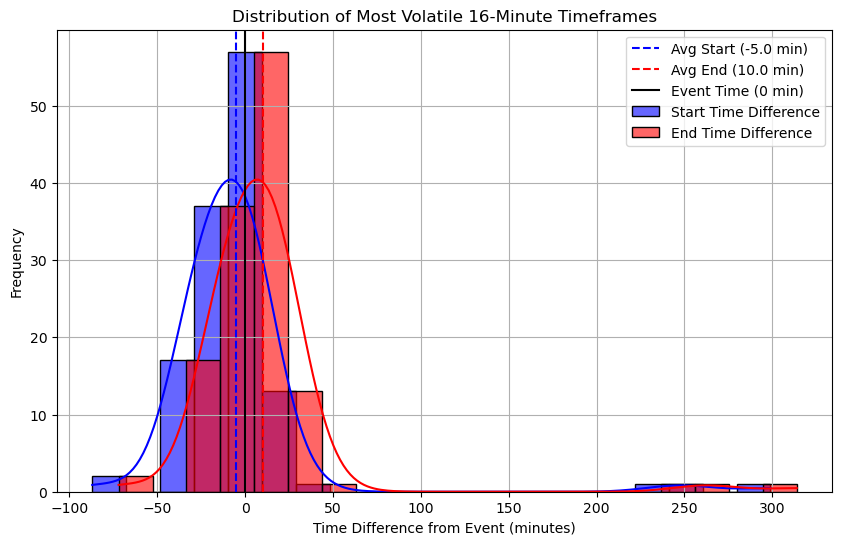

In [73]:
plot_time_differences(time_differences, avg_start, avg_end)

In [81]:
# Final dataframe after event time analysis
final_data = extract_relevant_fx_data(merged_df, macro_df)
len(final_data)

2079

#  <span style="color:blue"> Economic Data Seasonality report </span>

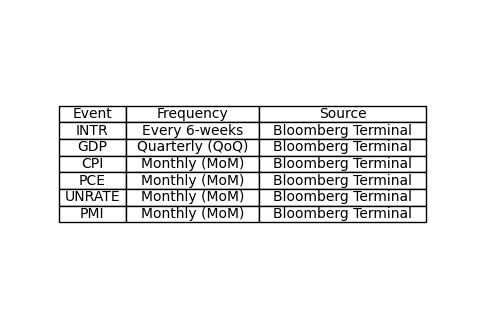

In [85]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("tight")
ax.axis("off")
table_data = [["INTR", "Every 6-weeks", "Bloomberg Terminal"],
              ["GDP", "Quarterly (QoQ)", "Bloomberg Terminal"],
              ["CPI", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PCE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["UNRATE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PMI", "Monthly (MoM)", "Bloomberg Terminal"]]

table = ax.table(cellText=table_data, colLabels=["Event", "Frequency", "Source"], cellLoc="center", loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])

plt.show()

#  <span style="color:blue"> Macro Event Importance Analysis </span>

1. Do some feature importance to keep the major macro data releases and do detailed analysis on these ones.
2. Explain that based on discussion with Risk Manager... from case studies these are athe most importants and refer to other papers too.

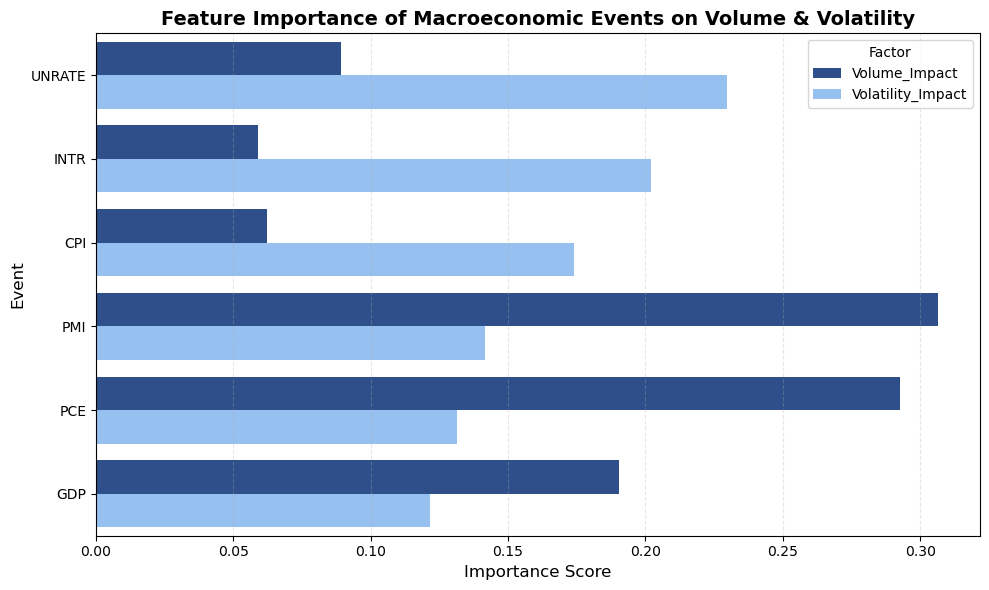

In [144]:
def compute_event_importance(df):
    """
    Computes the importance of macroeconomic events on Volume and Volatility.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores.
    """

    # One-Hot Encode Event Types
    events = pd.get_dummies(df["Ticker"])  
    df = pd.concat([df, events], axis=1)

    # Define target variables
    df["Volume_Impact"] = df[["USDEUR_Volume", "USDGBP_Volume", "USDCNH_Volume"]].mean(axis=1)
    df["Volatility_Impact"] = df[["USDEUR_VolatilityMultiplier", "USDGBP_VolatilityMultiplier", "USDCNH_Volatility_Multiplier"]].mean(axis=1)

    # Define features (Event Types)
    X = df[events.columns]
    y_volume = df["Volume_Impact"]
    y_volatility = df["Volatility_Impact"]

    # Train Random Forest Regressors
    rf_volume = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_volume.fit(X, y_volume)

    rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_volatility.fit(X, y_volatility)

    # Compute feature importance
    importance_df = pd.DataFrame({
        "Event": X.columns,
        "Volume_Impact": rf_volume.feature_importances_,
        "Volatility_Impact": rf_volatility.feature_importances_
    }).sort_values(by="Volatility_Impact", ascending=False)

    return importance_df

plot_event_importance(compute_event_importance(final_data))

1. Charts
2. Table with all info for CPI, IR, GDP, UR, JUMP, Vol increase from avg for all pairs

# <span style="color:blue"> Prior vs Now (volatility and importance)</span>

1. What is the volatility of the events over the past 3 years? This correlates with the one above (the one above is a combination of all 3 years)

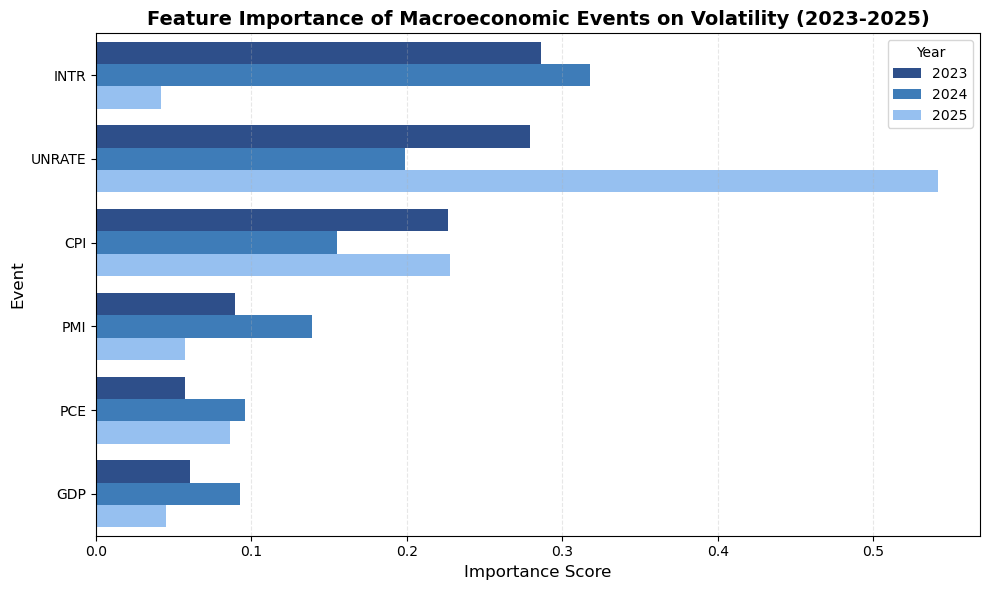

In [131]:
def compute_event_importance_by_year(df, years=[2023, 2024, 2025]):
    """
    Computes the importance of macroeconomic events on Volatility for specified years.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.
    - years (list): List of years to analyze.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores for each year.
    """

    importance_list = []

    for year in years:
        df_year = df[df.index.year == year].copy()

        if df_year.empty:
            continue

        # One-Hot Encode Event Types
        events = pd.get_dummies(df_year["Ticker"])  
        df_year = pd.concat([df_year, events], axis=1)

        # Define target variable (Volatility Impact)
        df_year["Volatility_Impact"] = df_year[["USDEUR_VolatilityMultiplier", "USDGBP_VolatilityMultiplier", "USDCNH_Volatility_Multiplier"]].mean(axis=1)

        # Define features (Event Types)
        X = df_year[events.columns]
        y_volatility = df_year["Volatility_Impact"]

        # Train Random Forest Regressor
        rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_volatility.fit(X, y_volatility)

        # Store feature importance
        importance_df = pd.DataFrame({
            "Event": X.columns,
            "Volatility_Impact": rf_volatility.feature_importances_,
            "Year": year
        })

        importance_list.append(importance_df)

    # Combine all years
    combined_importance = pd.concat(importance_list)

    # Sort by 2023 event importance
    sort_order = combined_importance[combined_importance["Year"] == 2024].sort_values(by="Volatility_Impact", ascending=False)["Event"]
    combined_importance["Event"] = pd.Categorical(combined_importance["Event"], categories=sort_order, ordered=True)

    return combined_importance

importance_results = compute_event_importance_by_year(final_data, years=[2023, 2024, 2025])
plot_event_importance_by_year(importance_results)

# Responses to CPI, IR, GDP, Unemployment Rate (R2 before appendix) - Jump (R4 p32) - Volatility Increase on each event table - Data Release Trend: Before/On/After

# Correlation of USD pairs and DXY price movements

1. Correlation heatmap
2. Identify which one moves first if not all together to see for arbritrage opportunity

-------